**Purpose**: Analyze the feedback that are embeded at the end of the tutorials in Galaxy Training Material

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from pprint import pprint
import datetime
import emoji

In [2]:
url = 'https://raw.githubusercontent.com/galaxyproject/training-material/main/metadata/feedback.csv'

In [3]:
str(datetime.datetime.now())

'2022-04-12 17:22:30.602993'

In [4]:
col_order = ['All',
            'Introduction to Galaxy Analyses',
            'Assembly',
            'Climate',
            'Computational chemistry',
            'Ecology',
            'Epigenetics',
            'Genome Annotation',
            'Imaging',
            'Metabolomics',
            'Metagenomics',
            'Proteomics',
            'Sequence analysis',
            'Statistics and machine learning',
            'Transcriptomics',
            'Variant Analysis',
            'Visualisation',
            'Using Galaxy and Managing your Data',
            'Galaxy Server administration',
            'Development in Galaxy',
            'Contributing to the Galaxy Training Material',
            'Teaching and Hosting Galaxy training']

# Load the feedback

In [5]:
df = (pd.read_csv(url, index_col=0)
        .fillna('')
        .assign(
            date=lambda x: pd.to_datetime(x['date']),
            month=lambda x: pd.to_datetime(x['month']).dt.to_period('M')))

In [6]:
df.head()

,note,pro,con,anonymous,tutorial,topic,month,date
0,5,"very detailed and easy to follow, even for a c...",,,Galaxy 101,Introduction to Galaxy Analyses,2018-09,2018-09-14
1,5,"very detailed and easy to follow, thank you",,,Introduction to Genomics and Galaxy,Introduction to Galaxy Analyses,2018-09,2018-09-15
2,2,,,,Identification of the binding sites of the Est...,Epigenetics,2018-09,2018-09-16
4,5,"Well structured, easy to understand.",,,From peaks to genes,Introduction to Galaxy Analyses,2018-09,2018-09-17
5,5,The data clean-up was thoroughly covered. Ever...,Using the mock community. More light on rationale,,16S Microbial Analysis with mothur (extended),Metagenomics,2018-09,2018-09-17


# General stats about feedback

Feedback number:

In [7]:
# number of rows
len(df)

1828

Feedback number over time

In [8]:
nb_per_months_df = (df
                 .groupby(df.month)
                 .count()
                 .filter(['date'])
                 .rename(columns = {'date': 'All'}))

Top 10 tutorials with feedbacks

In [9]:
(df
    .groupby(by="tutorial")
    .count()
    .sort_values('date', ascending=False)
    .date
    .head(10))

tutorial
A short introduction to Galaxy                        303
Quality Control                                       142
Galaxy 101                                            111
Reference-based RNA-Seq data analysis                  78
From peaks to genes                                    70
Introduction to Genomics and Galaxy                    61
Mapping                                                56
Galaxy 101 for everyone                                40
NGS data logistics                                     39
Visualization of RNA-Seq results with Volcano Plot     38
Name: date, dtype: int64

In [10]:
grouped_by_topic = df.groupby(by="topic")

# Aggregate the feedbacks and notes

In [11]:
def get_notes(df, name):
    '''Aggregage the notes
    
    :df: dataframe with all feedbacks
    
    :return: dataframe object with aggregated notes
    '''
    return (df.note
        .value_counts(sort=False)
        .to_frame()
        .rename(columns= {'note': name}))

In [12]:
notes = get_notes(df, 'All')

In [13]:
def get_topic_df(grouped_by_topic, topic, notes):
    '''Extract the dataframe for a topic and plot note histogram
    
    :grouped_by_topic: groupby object grouping by topic
    :topic: topic to extract
    
    :return: dataframe object for the topic
    '''
    topic_df = (grouped_by_topic
        .get_group(topic)
        .drop('topic', 1))
    
    notes = pd.concat([notes, get_notes(topic_df, topic)], axis=1)
    return topic_df, notes

In [14]:
for topic in grouped_by_topic.groups:
    print(topic)
    topic_df, notes = get_topic_df(grouped_by_topic, topic, notes)
    topic_name = topic.lower().replace(' ', '-')
    m_df = (topic_df
        .groupby(by='month')
        .count()
        .filter(['date'])
        .rename(columns = {'date': topic}))
    nb_per_months_df = nb_per_months_df.merge(m_df, how='outer', left_index=True, right_index=True)
nb_per_months_df = (nb_per_months_df
    .fillna(0))
nb_per_months_df = nb_per_months_df[col_order]
notes = notes[col_order]

Assembly
Climate
Computational chemistry
Contributing to the Galaxy Training Material
Development in Galaxy
Ecology
Epigenetics
Foundations of Data Science
Galaxy Server administration
Genome Annotation
Imaging
Introduction to Galaxy Analyses
Metabolomics
Metagenomics
Proteomics
Sequence analysis
Statistics and machine learning
Teaching and Hosting Galaxy training
Transcriptomics
Using Galaxy and Managing your Data
Variant Analysis
Visualisation


/tmp/ipykernel_187847/3507862895.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  topic_df = (grouped_by_topic


Feedback number per topics

In [15]:
(nb_per_months_df
    .sum(axis=0))

All                                             1828.0
Introduction to Galaxy Analyses                  641.0
Assembly                                          63.0
Climate                                            6.0
Computational chemistry                           19.0
Ecology                                            6.0
Epigenetics                                       43.0
Genome Annotation                                 42.0
Imaging                                            6.0
Metabolomics                                       8.0
Metagenomics                                      75.0
Proteomics                                        42.0
Sequence analysis                                204.0
Statistics and machine learning                   54.0
Transcriptomics                                  279.0
Variant Analysis                                  66.0
Visualisation                                      8.0
Using Galaxy and Managing your Data               64.0
Galaxy Ser

In [16]:
nb_per_months_df

,All,Introduction to Galaxy Analyses,Assembly,Climate,Computational chemistry,Ecology,Epigenetics,Genome Annotation,Imaging,Metabolomics,...,Sequence analysis,Statistics and machine learning,Transcriptomics,Variant Analysis,Visualisation,Using Galaxy and Managing your Data,Galaxy Server administration,Development in Galaxy,Contributing to the Galaxy Training Material,Teaching and Hosting Galaxy training
month,,,,,,,,,,,,,,,,,,,,,
2018-09,28,12,2.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,...,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10,42,24,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,5.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0
2018-11,31,20,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,4.0,0.0,1.0,2.0,0.0,0.0,0.0
2018-12,14,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2019-01,24,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,3.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0
2019-02,21,10,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,...,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
2019-03,24,6,3.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,3.0,2.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2019-04,40,19,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2019-05,22,8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


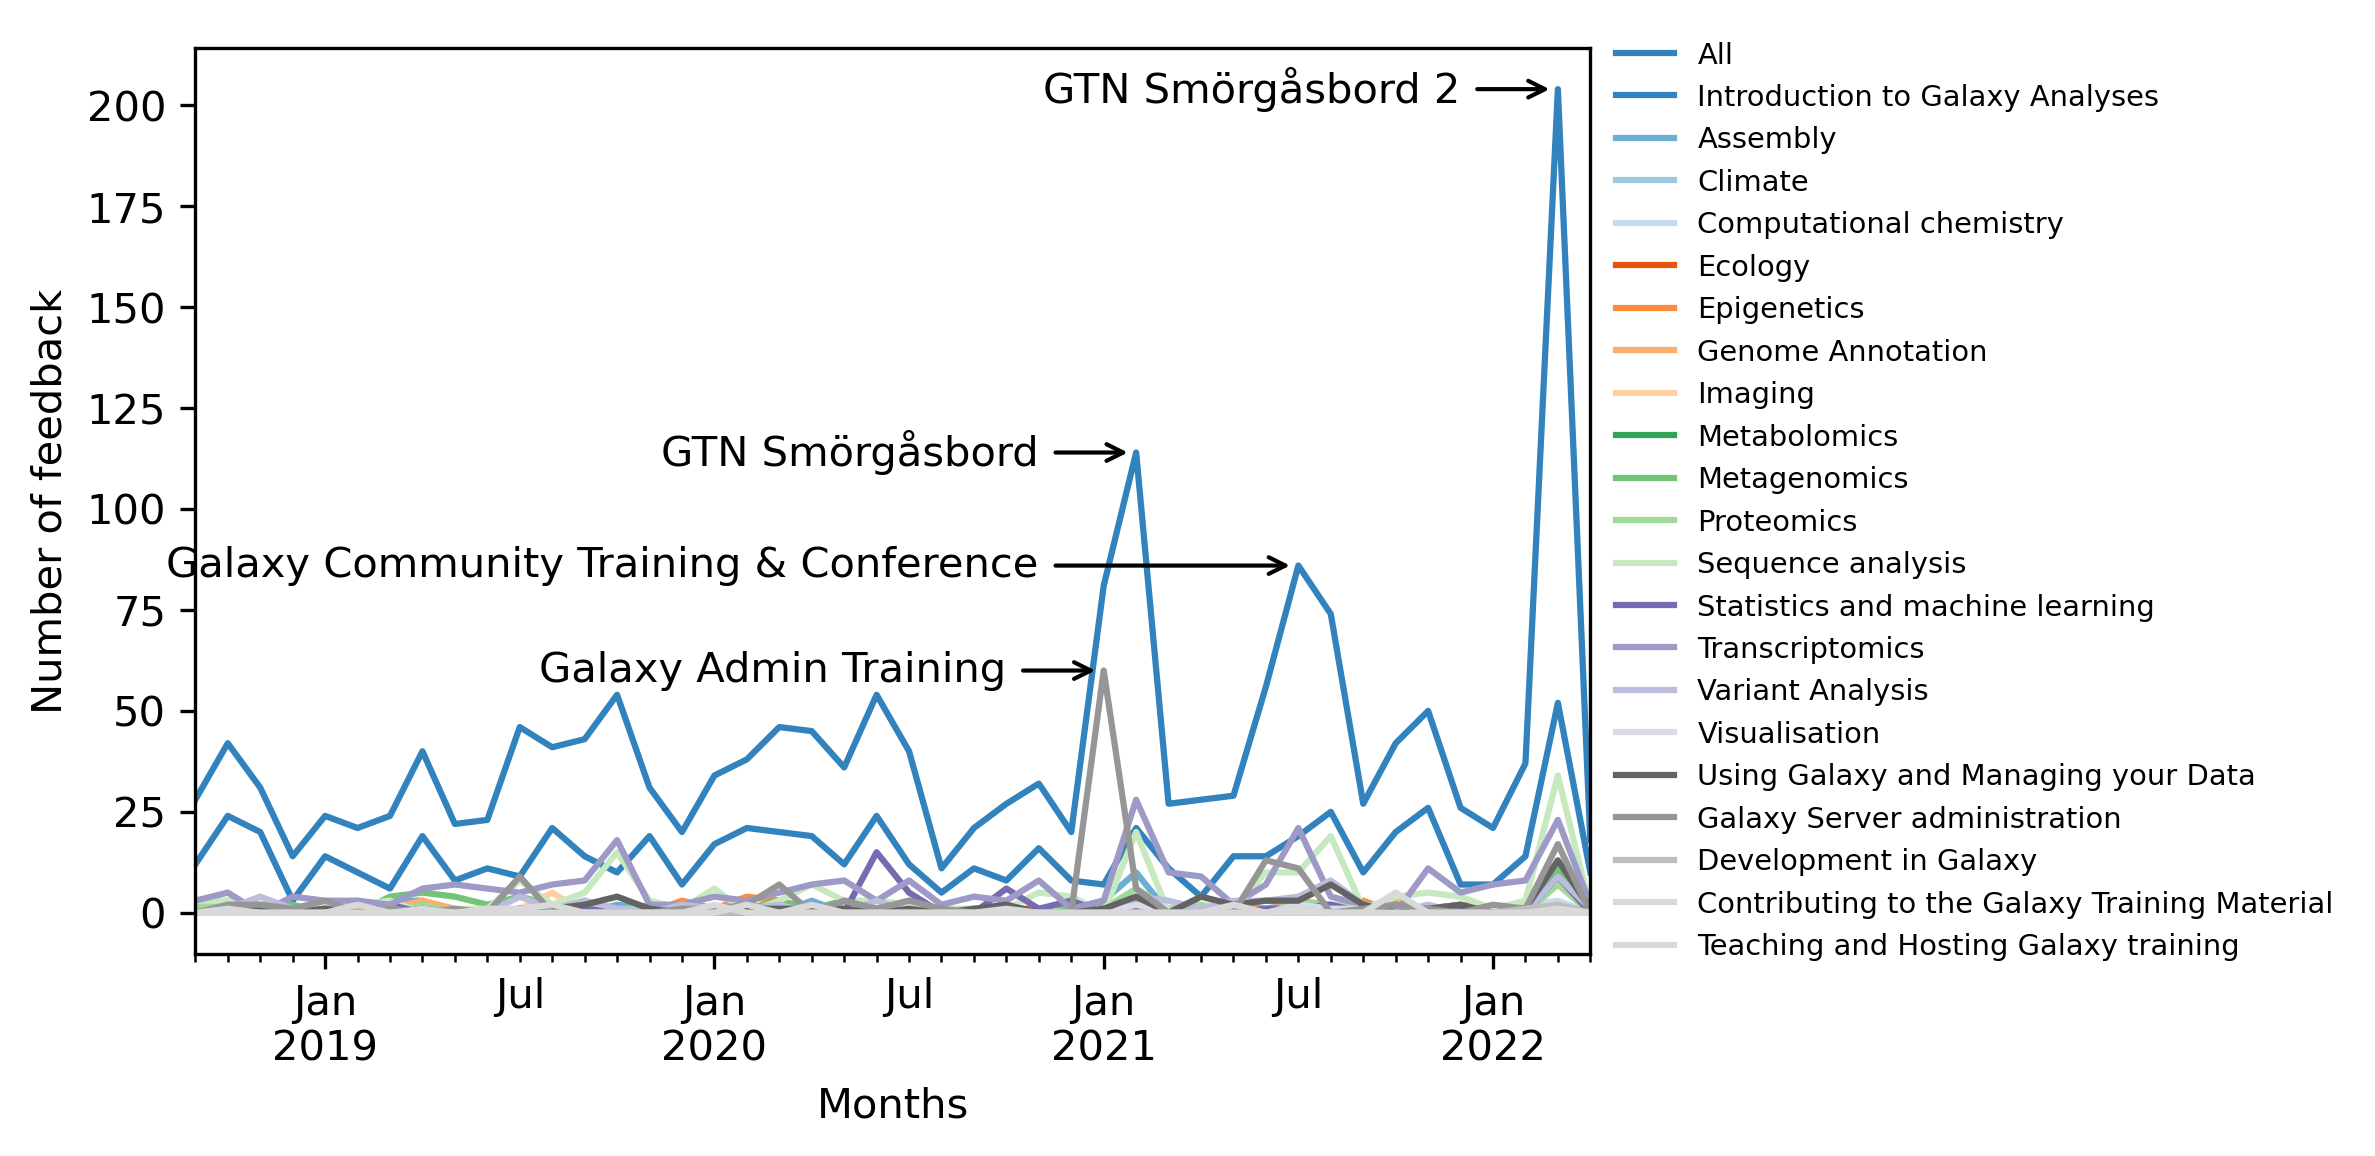

In [17]:
fig, ax = plt.subplots()
fig.set_dpi(300)
(nb_per_months_df
    .plot(ax=ax, colormap='tab20c'))
plt.xlabel('Months')
plt.ylabel('Number of feedback')
plt.annotate(
    'Galaxy Admin Training',
    xy=('2021-01-01', nb_per_months_df['Galaxy Server administration']['2021-01']),
    xycoords='data',
    xytext=('2020-10-01', nb_per_months_df['Galaxy Server administration']['2021-01']),
    arrowprops=dict(arrowstyle="->"),
    horizontalalignment='right',
    verticalalignment='center')
plt.annotate(
    'GTN Smörgåsbord',
    xy=('2021-02-15', nb_per_months_df['All']['2021-02']),
    xycoords='data',
    xytext=('2020-11-01', nb_per_months_df['All']['2021-02']),
    arrowprops=dict(arrowstyle="->"),
    horizontalalignment='right',
    verticalalignment='center')
plt.annotate(
    'Galaxy Community Training & Conference',
    xy=('2021-07-01', nb_per_months_df['All']['2021-07']),
    xycoords='data',
    xytext=('2020-11-01', nb_per_months_df['All']['2021-07']),
    arrowprops=dict(arrowstyle="->"),
    horizontalalignment='right',
    verticalalignment='center')
plt.annotate(
    'GTN Smörgåsbord 2',
    xy=('2022-03-15', nb_per_months_df['All']['2022-03']),
    xycoords='data',
    xytext=('2021-12-01', nb_per_months_df['All']['2022-03']),
    arrowprops=dict(arrowstyle="->"),
    horizontalalignment='right',
    verticalalignment='center')
ax.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    fontsize='x-small')
plt.savefig('../images/feedback.png', bbox_inches='tight')

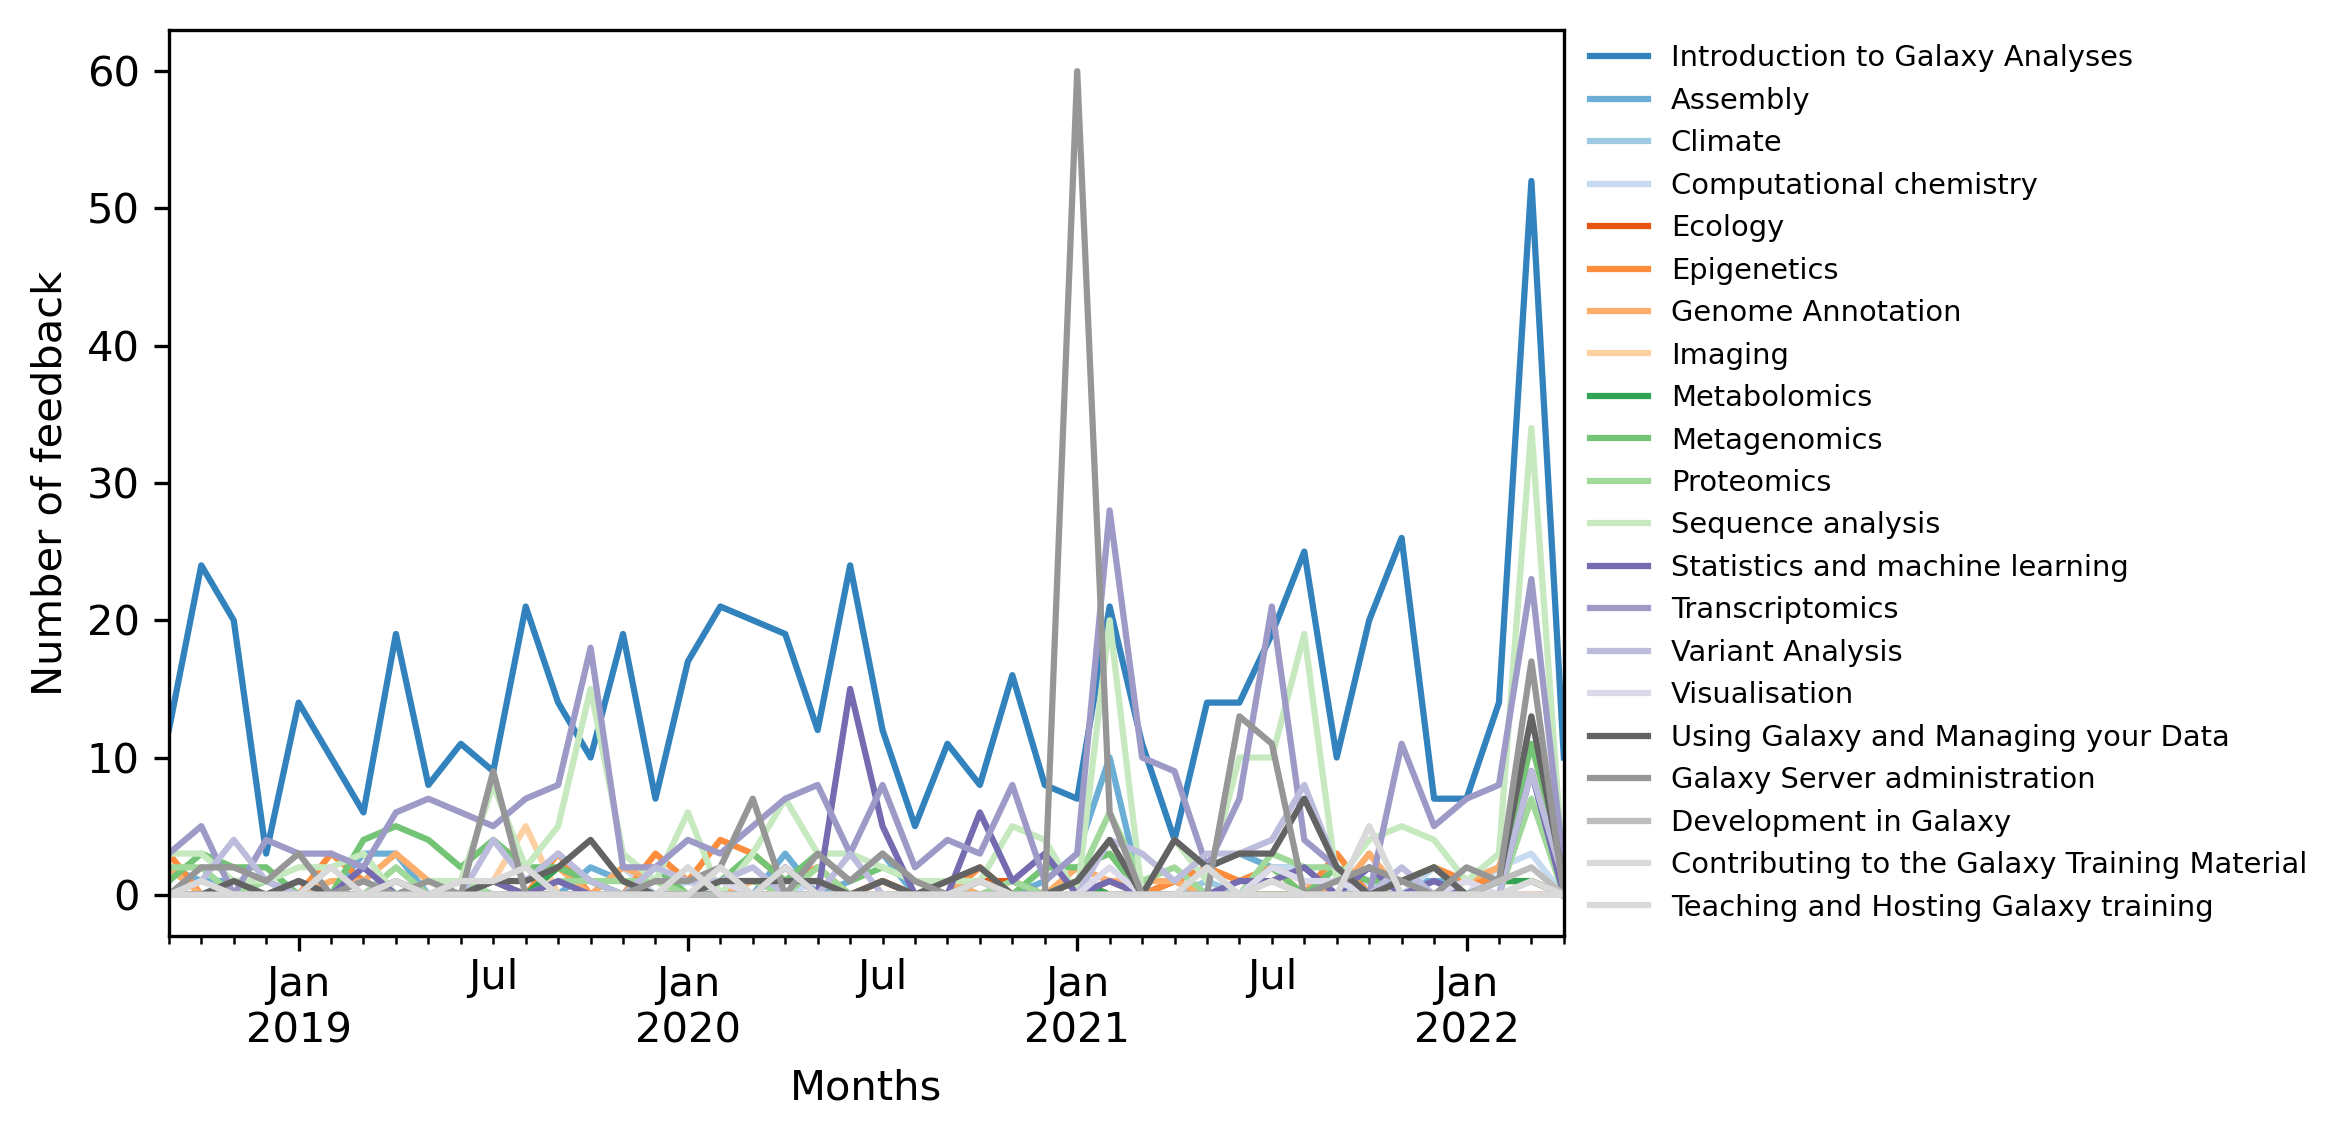

In [18]:
fig, ax = plt.subplots()
fig.set_dpi(300)
(nb_per_months_df
    .drop(columns=['All'])
    .plot(ax=ax, colormap='tab20c'))
plt.xlabel('Months')
plt.ylabel('Number of feedback')
ax.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    fontsize='x-small')

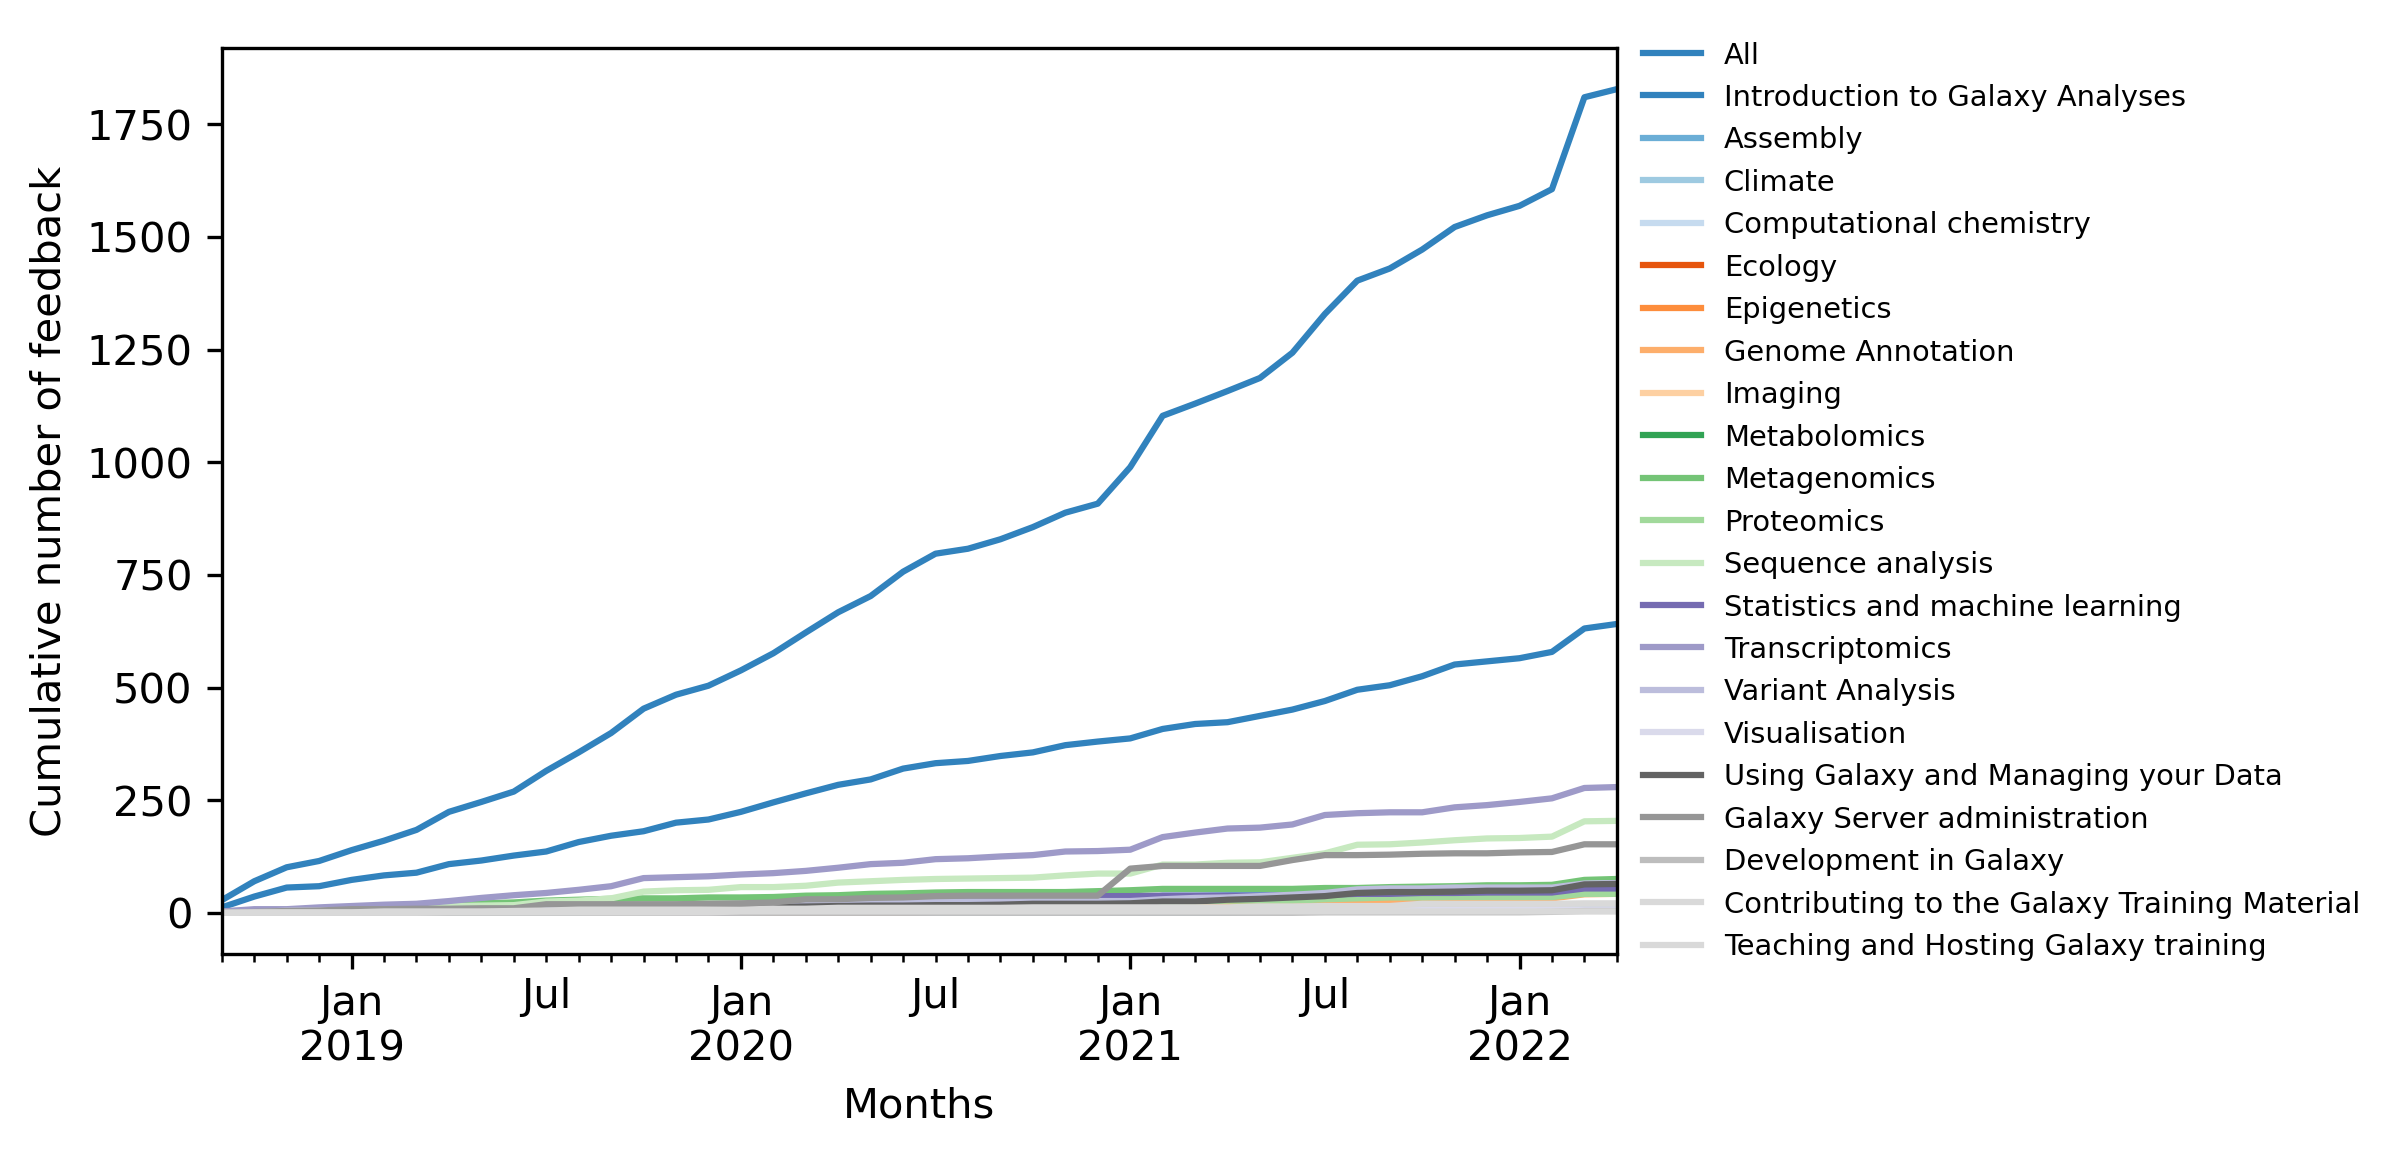

In [19]:
fig, ax = plt.subplots()
fig.set_dpi(300)
(nb_per_months_df
    .cumsum()
    .plot(ax=ax, colormap='tab20c'))
plt.xlabel('Months')
plt.ylabel('Cumulative number of feedback')
ax.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    fontsize='x-small')

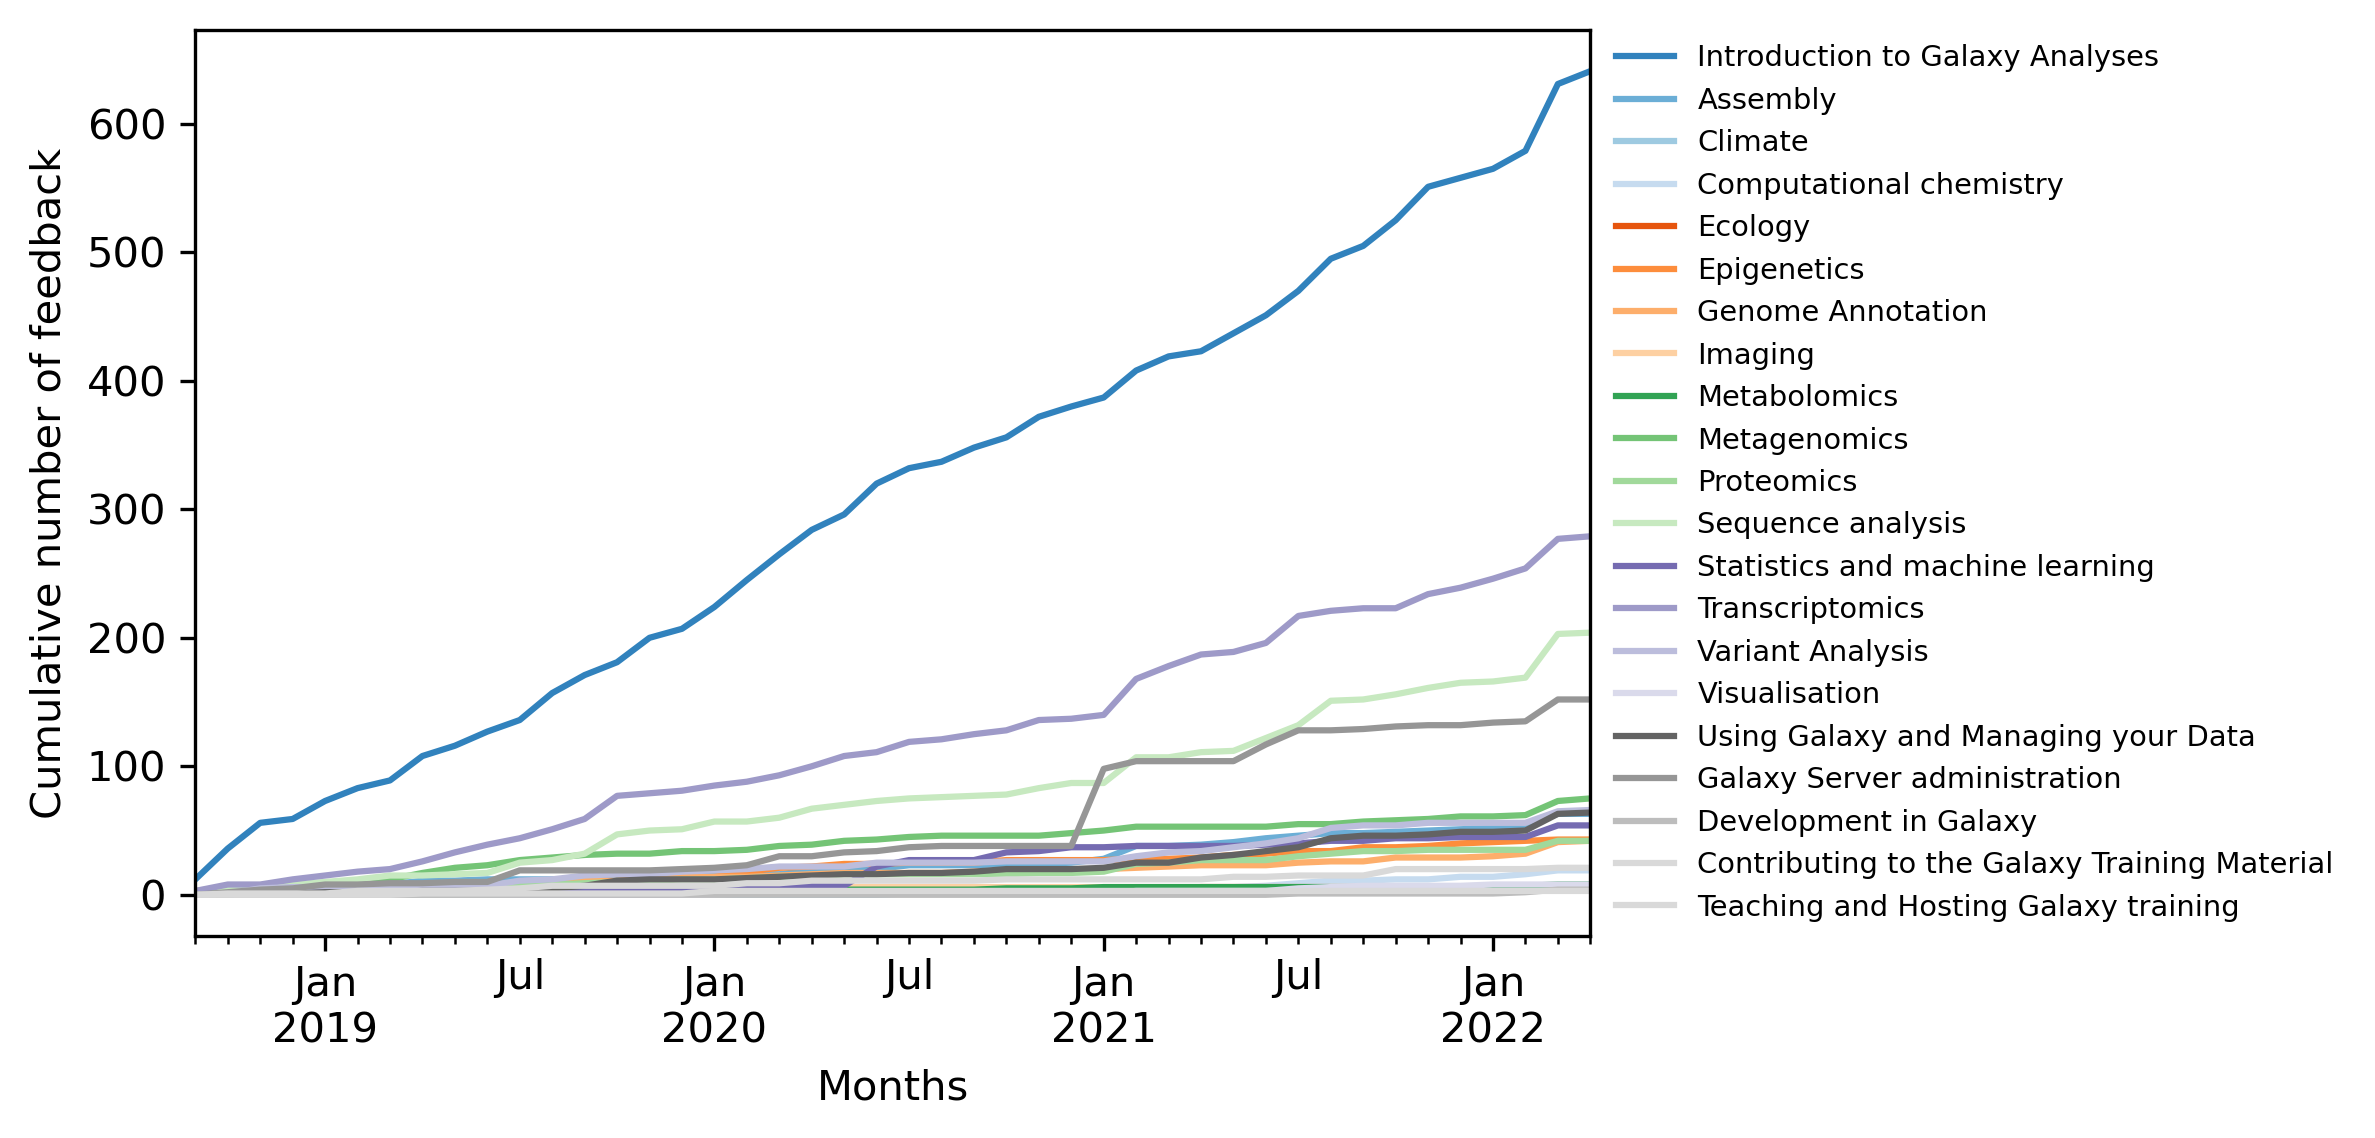

In [20]:
fig, ax = plt.subplots()
fig.set_dpi(300)
(nb_per_months_df
    .drop(columns=['All'])
    .cumsum()
    .plot(ax=ax, colormap='tab20c'))
plt.xlabel('Months')
plt.ylabel('Cumulative number of feedback')
ax.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    fontsize='x-small')

In [21]:
nb_per_months_df

,All,Introduction to Galaxy Analyses,Assembly,Climate,Computational chemistry,Ecology,Epigenetics,Genome Annotation,Imaging,Metabolomics,...,Sequence analysis,Statistics and machine learning,Transcriptomics,Variant Analysis,Visualisation,Using Galaxy and Managing your Data,Galaxy Server administration,Development in Galaxy,Contributing to the Galaxy Training Material,Teaching and Hosting Galaxy training
month,,,,,,,,,,,,,,,,,,,,,
2018-09,28,12,2.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,...,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-10,42,24,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,5.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0
2018-11,31,20,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,4.0,0.0,1.0,2.0,0.0,0.0,0.0
2018-12,14,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2019-01,24,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,3.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0
2019-02,21,10,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,...,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
2019-03,24,6,3.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,3.0,2.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2019-04,40,19,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2019-05,22,8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Notes

In [22]:
def plot_note_histogram(s, title):
    plt.figure()
    s.plot(kind='barh', color='k', ylim=(0,5), xlim=(0,1), title=title)
    plt.xlabel('Proportion of feedback')
    plt.show()

In [23]:
notes = (notes
         .fillna(0.0)
         .astype(int)
         .rename(index = {0: 'No value'}))
notes_prop = (notes/notes.sum().round(2))

In [24]:
notes

,All,Introduction to Galaxy Analyses,Assembly,Climate,Computational chemistry,Ecology,Epigenetics,Genome Annotation,Imaging,Metabolomics,...,Sequence analysis,Statistics and machine learning,Transcriptomics,Variant Analysis,Visualisation,Using Galaxy and Managing your Data,Galaxy Server administration,Development in Galaxy,Contributing to the Galaxy Training Material,Teaching and Hosting Galaxy training
No value,31,4,2,0,0,0,1,2,0,0,...,1,0,10,0,0,2,6,0,0,0
1,62,13,1,0,3,0,4,5,0,0,...,2,2,15,6,1,3,1,0,1,0
2,35,11,2,0,0,0,1,4,0,0,...,4,1,3,2,0,3,0,0,1,0
3,88,24,3,0,1,0,1,2,0,1,...,15,3,15,2,1,4,7,0,3,0
4,334,105,15,3,5,1,10,10,0,0,...,35,11,56,11,2,18,25,2,0,1
5,1278,484,40,3,10,5,26,19,6,7,...,147,37,180,45,4,34,113,2,16,2


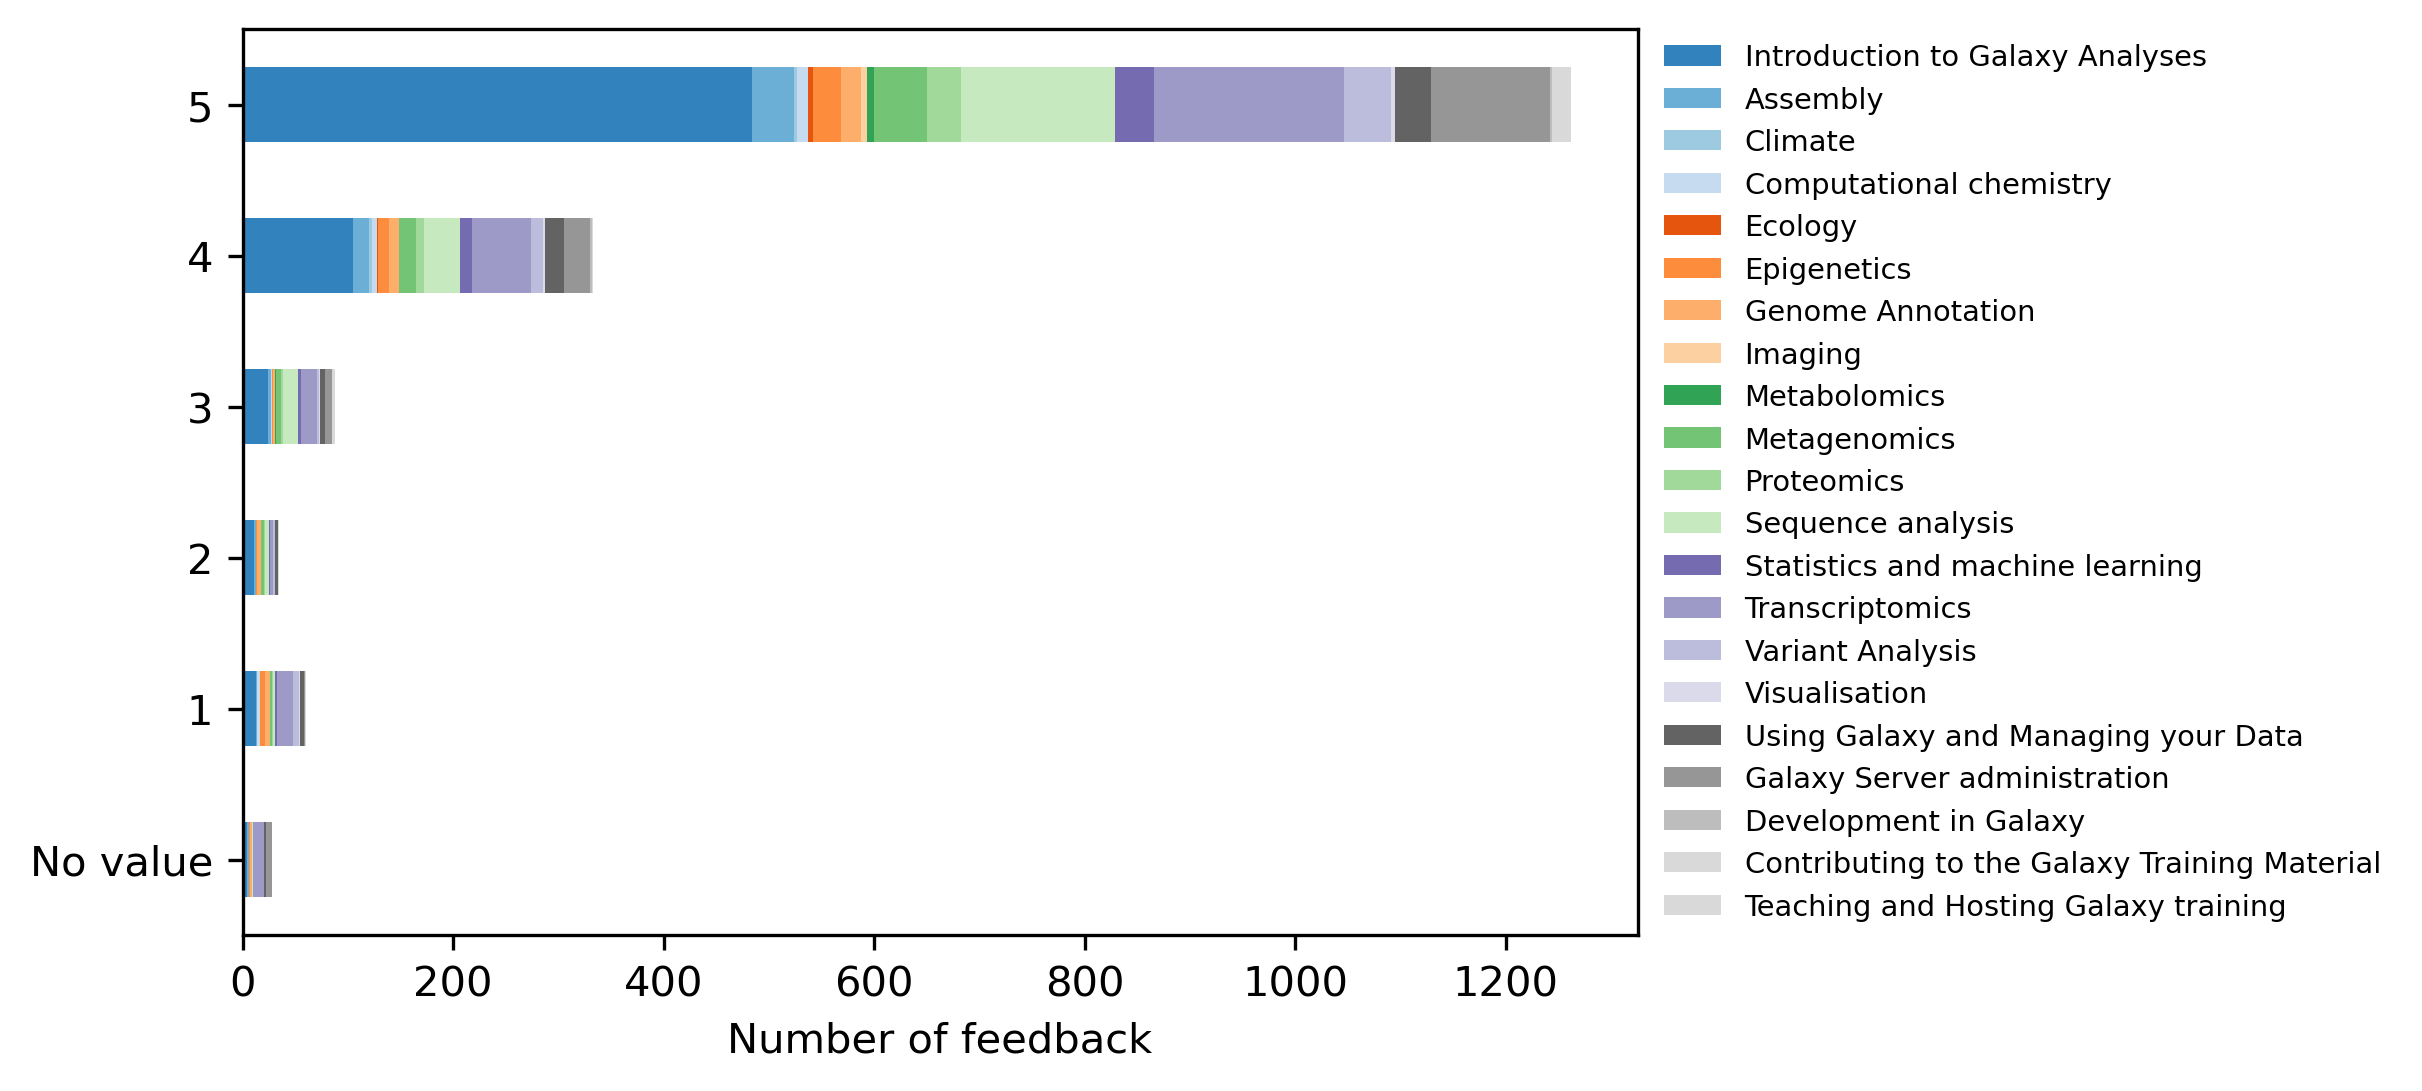

In [25]:
fig, ax = plt.subplots()

fig.set_dpi(300)
(notes
    .drop(columns=['All'])
    .plot.barh(stacked=True, ax=ax, colormap='tab20c'))
plt.xlabel('Number of feedback')
ax.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    fontsize='x-small')
plt.savefig('../images/feedback-scores.png', bbox_inches='tight')